In [22]:
from binance.client import Client
import config
import pandas as pd

In [23]:
exchange = Client(api_key=config.key,api_secret=config.secret,tld='us',testnet=True)

In [127]:
def getData(symbol,time,client):
    """
    1504541580000, // UTC timestamp in milliseconds, integer
    4235.4,        // (O)pen price, float
    4240.6,        // (H)ighest price, float
    4230.0,        // (L)owest price, float
    4230.7,        // (C)losing price, float
    37.72941911    // (V)olume float (usually in terms of the base currency, the exchanges docstring may list whether quote or base units are used)
    """
    klines = client.get_historical_klines(symbol=symbol, interval=time)

    columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore']
    df = pd.DataFrame(klines, columns=columns)

    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    # df['timestamp'] = df['timestamp'].dt.tz_localize('UTC')
    # df['timestamp'] = df['timestamp'].dt.tz_convert('America/Chicago')
    

    df = df[['timestamp', 'open', 'high', 'low', 'close', 'volume']]
    df.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
    #df.set_index('Date', inplace=True)
    df['Open'] = df['Open'].astype(float)
    df['High'] = df['High'].astype(float)
    df['Low'] = df['Low'].astype(float)
    df['Close'] = df['Close'].astype(float)
    df['Volume'] = df['Volume'].astype(float)
    return df

In [25]:
def calculate_macd(data, **params):
    """
    Calculates the MACD line, signal line, and zero line for a given DataFrame of stock data.
    :param data: DataFrame containing stock data with at least a 'Close' column and a DatetimeIndex.
    :param EMA Long Period: The period length for the long EMA. Default is 26.
    :param EMA Short Period: The period length for the short EMA. Default is 12.
    :param Signal Line Period: The period length for the signal line. Default is 9.
    :return: DataFrame containing the MACD line, signal line, and zero line as columns, with the same index as the input DataFrame.
    """
    ema_long = data['Close'].ewm(span=params['EMA Long Period'], adjust=False).mean()
    ema_short = data['Close'].ewm(span=params['EMA Short Period'], adjust=False).mean()
    macd_line = ema_short - ema_long
    signal_line = macd_line.ewm(span=params['Signal Line Period'], adjust=False).mean()
    zero_line = pd.Series(0, index=data.index)
    macd_df = pd.concat([macd_line, signal_line, zero_line], axis=1)
    macd_df.columns = ['MACD_line', 'Signal_line', 'Zero_line']
    return macd_df


In [41]:
class MyStrategy:
    
    def generate_signals_backtest(self,data,user_input,**params):
       
        # data['Signal'] = data['Signal'].astype("float")
        if user_input == 'MACD':
            signals = self.MACD_strategy(data,**params)
        elif user_input == 'RSI':
            signals = self.RSI_strategy(data,**params)
        return signals 
    
    def RSI_strategy(self,data,**params):
        from ta.momentum import rsi
        
        # Define your trading signals here
        lower_limit= params['Buy Threshold'] 
        upper_limit = params['Sell Threshold']
        
        # Calculate the RSI indicator
        #data["RSI"] = rsi(data["Close"],window=params['RSI Period'])
        data['RSI']= ta.momentum.RSIIndicator(data["Close"], window=params['RSI Period']).rsi()
       
        #data = rsi_calculation(data,params['RSI Period'])

        #data["RSI"] = ta.momentum.RSIIndicator(close=data["close"], window=params['RSI Period']).rsi()
        data = data.dropna()
        data = data.reset_index(drop=True)
        # # Generate the signals based on the RSI value
        #data["signal"] = data['RSI'].apply(lambda x: 1 if x < lower_limit else -1 if x > upper_limit else 0)
        # Create the 'signal' column
        #data = data.copy()
        data['Signal'] = 0
        
        
        # Set a flag to track if we're currently in a position
        in_position = False
        
        # Loop through each row and set the signal based on the RSI and previous position
      
        for i in range(1, len(data)):
            rsi_value = data['RSI'][i]
           
            if in_position:
                # If we're currently in a position, continue holding until a Sell signal
                if rsi_value >= upper_limit:
                    data['Signal'][i] = -1
                    in_position = False
                else:
                    data['Signal'][i] = 0
            else:
                # If we're not currently in a position, Buy if RSI is below the lower limit
                if rsi_value <= lower_limit:
                    data['Signal'][i] = 1
                    in_position = True
                else:
                    data['Signal'][i] = 0
        return data
    def MACD_strategy(self,data,**params):
        #MACD trading strategy
        macd_df = calculate_macd(data, **params)
        data = pd.concat([data, macd_df], axis=1)
        # Set a flag to track if we're currently in a position
        in_position = False
        
        # Loop through each row and set the signal based on the RSI and previous position
        data['Signal'] = 0
        for i in range(1, len(data)):
            macd = data['MACD_line'][i]
            zero_line = data['Zero_line'][i]
            signal_line = data['Signal_line'][i]
           
            if in_position:
                # If we're currently in a position, continue holding until a Sell signal
                if (macd < signal_line) & (macd > zero_line) & (signal_line > zero_line): 
                    data['Signal'][i] = -1
                    in_position = False
                else:
                    data['Signal'][i] = 0
            else:
                # If we're not currently in a position, Buy if RSI is below the lower limit
                if (macd > signal_line) & (macd < zero_line) & (signal_line < zero_line):
                    data['Signal'][i] = 1
                    in_position = True
                else:
                    data['Signal'][i] = 0

        return data

In [27]:
 # #MACD
symbol = "ETHUSDT"
time_frame = '15m'
df = getData(symbol,time_frame,exchange) 
strategy = MyStrategy()

In [28]:
inital_parameters = {'EMA Long Period': 11.0, 'EMA Short Period': 6.0, 'Signal Line Period': 14.0}

In [45]:
signals = strategy.generate_signals_backtest(df,'MACD',**inital_parameters)
signals

/tmp/ipykernel_3239/1502439823.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Signal'][i] = 0
/tmp/ipykernel_3239/1502439823.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Signal'][i] = 1
/tmp/ipykernel_3239/1502439823.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Signal'][i] = 0
/tmp/ipykernel_3239/1502439823.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

,Open,High,Low,Close,Volume,MACD_line,Signal_line,Zero_line,Signal
Date,,,,,,,,,
2023-03-19 08:30:00-05:00,1781.18,1782.20,1773.57,1775.87,167.39280,0.000000,0.000000,0,0
2023-03-19 08:45:00-05:00,1775.74,1777.55,1775.11,1775.75,110.83467,-0.014286,-0.001905,0,0
2023-03-19 09:00:00-05:00,1775.80,1780.32,1775.80,1777.40,140.73523,0.174320,0.021592,0,0
2023-03-19 09:15:00-05:00,1777.17,1787.28,1775.46,1787.05,185.24070,1.427093,0.208992,0,0
2023-03-19 09:30:00-05:00,1787.06,1799.90,1783.23,1786.56,194.17433,2.046502,0.453993,0,0
...,...,...,...,...,...,...,...,...,...
2023-03-29 17:15:00-05:00,1789.33,1792.95,1786.12,1792.71,131.45619,-2.603662,-0.608044,0,0
2023-03-29 17:30:00-05:00,1791.88,1794.60,1789.15,1789.95,108.42574,-2.934045,-0.918177,0,0
2023-03-29 17:45:00-05:00,1789.98,1791.62,1787.74,1790.41,72.10450,-2.936223,-1.187250,0,0


In [30]:
# df = pd.DataFrame(columns=['Date', 'Open', 'High', 'Low', 'Close','Signal'])

# # Populate the DataFrame with your data
# df['Date'] = ['2022-01-01', '2022-01-02', '2022-01-03','2022-01,04']
# df['Open'] = [100.0, 101.0, 99.0,100.0]
# df['High'] = [102.0, 103.0, 100.0,105.0]
# df['Low'] = [99.0, 99.5, 98.0,97.8]
# df['Close'] = [101.0, 102.5, 98.5,103.5]

# df['Signal'] = [1, 0, -1,0]

In [31]:
import backtrader as bt
import matplotlib.pyplot as plt
%matplotlib inline


In [32]:
class MyStrategy(bt.Strategy):
    def __init__(self):
        self.signal = self.data.signal

    def next(self):
        if self.signal == 1:
            self.buy()
        elif self.signal == -1:
            self.sell()



In [33]:
signals.dtypes

Open           float64
High           float64
Low            float64
Close          float64
Volume         float64
MACD_line      float64
Signal_line    float64
Zero_line        int64
Signal           int64
dtype: object

In [34]:
# import yfinance as yf
# signals = yf.download('AAPL',start='2015-01-01')

In [43]:
signals

,Open,High,Low,Close,Volume,MACD_line,Signal_line,Zero_line,Signal
Date,,,,,,,,,
2023-03-19 08:30:00-05:00,1781.18,1782.20,1773.57,1775.87,167.39280,0.000000,0.000000,0,0
2023-03-19 08:45:00-05:00,1775.74,1777.55,1775.11,1775.75,110.83467,-0.014286,-0.001905,0,0
2023-03-19 09:00:00-05:00,1775.80,1780.32,1775.80,1777.40,140.73523,0.174320,0.021592,0,0
2023-03-19 09:15:00-05:00,1777.17,1787.28,1775.46,1787.05,185.24070,1.427093,0.208992,0,0
2023-03-19 09:30:00-05:00,1787.06,1799.90,1783.23,1786.56,194.17433,2.046502,0.453993,0,0
...,...,...,...,...,...,...,...,...,...
2023-03-29 17:15:00-05:00,1789.33,1792.95,1786.12,1792.71,131.45619,-2.603662,-0.608044,0,0
2023-03-29 17:30:00-05:00,1791.88,1794.60,1789.15,1789.95,108.42574,-2.934045,-0.918177,0,0
2023-03-29 17:45:00-05:00,1789.98,1791.62,1787.74,1790.41,72.10450,-2.936223,-1.187250,0,0


In [36]:
class MyPandasData(bt.feeds.PandasData):
    lines = ('signal',)  # specify the 'signal' column as a LineSeries

    params = (
        ('datetime', 'Date'),  # specify the name of the datetime column
        ('open', 'Open'),
        ('high', 'High'),
        ('low', 'Low'),
        ('close', 'Close'),
        ('volume', 'Volume'),
        ('openinterest', None),
        ('signal', -1),  # specify the index of the 'signal' column
    )


In [37]:

cerebro = bt.Cerebro()
#data = bt.feeds.PandasData(dataname=signals)
data = MyPandasData(dataname=signals)
cerebro.adddata(data)
cerebro.addstrategy(MyStrategy)
# Add analyzers to cerebro
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe_ratio')
cerebro.addanalyzer(bt.analyzers.Transactions, _name='transactions')
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='trade_analyzer')
results = cerebro.run()

ValueError: 'date' is not in list

In [ ]:
cerebro.plot()
plt.show()



<IPython.core.display.Javascript object>

In [ ]:
fig = cerebro.plot()[0][0]
fig.savefig("myplot1.png")

<IPython.core.display.Javascript object>

In [ ]:
# Get performance metrics
sharpe_ratio = results[0].analyzers.sharpe_ratio.get_analysis()
transactions = results[0].analyzers.transactions.get_analysis()
trade_analyzer = results[0].analyzers.trade_analyzer.get_analysis()
sharpe_ratio
# print(f"Sharpe ratio: {sharpe_ratio['sharperatio']:.2f}")
# print(f"Total trades: {transactions['total']}")
# print(f"Win rate: {trade_analyzer['won']['total'] / trade_analyzer['total']['total']:.2f}")

OrderedDict([('sharperatio', None)])

In [ ]:
from backtesting import Strategy
from backtesting.lib import crossover

class MACDStrategy(Strategy):
    
    def init(self):
        # Set the MACD parameters
        self.macd_fast = 12
        self.macd_slow = 26
        self.macd_signal = 9
        
        # Add the MACD indicator to the strategy
        self.macd = self.I(talib.MACD, self.data.Close, self.macd_fast, self.macd_slow, self.macd_signal)
        
    def next(self):
        if crossover(self.macd.macd, self.macd.signal):
            self.buy()
        elif crossover(self.macd.signal, self.macd.macd):
            self.sell()


In [ ]:
# import backtesting
# import pandas as pd
# from backtesting import Backtest, Strategy


# class MyStrategy(Strategy):
    
#     def init(self):
#         # Call parent constructor
        
        
#         # Define signal
#         self.signal = self.data.Signal
        
      
        
#     def next(self):
#         if self.signal == -1:
#             self.sell()
#         elif self.signal == 1:
#             # Calculate position size
#             size = self.get_cash() // self.data.Close
#             self.buy(size=size)

# # Define backtest parameters
# bt = Backtest(signals, MyStrategy, cash=10000, commission=0.001)

# # Run backtest
# results = bt.run()

# # Print performance metrics
# print(results)


Start                     2023-03-19 08:00...
End                       2023-03-29 17:45...
Duration                     10 days 09:45:00
Exposure Time [%]                         0.0
Equity Final [$]                      10000.0
Equity Peak [$]                       10000.0
Return [%]                                0.0
Buy & Hold Return [%]                0.479187
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     0.0
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              NaN
Max. Drawdown [%]                        -0.0
Avg. Drawdown [%]                         NaN
Max. Drawdown Duration                    NaN
Avg. Drawdown Duration                    NaN
# Trades                                    0
Win Rate [%]                              NaN
Best Trade [%]                            NaN
Worst Trade [%]                           NaN
Avg. Trade [%]                    

In [84]:
import itertools
from tqdm import tqdm
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore")
class Backtester:
    def __init__(self, data, strategy, selected_strategy, initial_account_value, investment_amount, fee_per_trade):
        self.data = data
        self.strategy = strategy
        self.selected_strategy = selected_strategy
        self.initial_account_value = initial_account_value
        self.investment_amount = investment_amount
        self.fee_per_trade = fee_per_trade


    def run_backtest(self, **kwargs):
        params = kwargs
        # Create a copy of the data to avoid modifying the original
        data = self.data.copy()
        
        # Apply the strategy to the data
        signals = self.strategy.generate_signals_backtest(data, self.selected_strategy, **params)

        # Set up variables to track portfolio performance
        num_trades = 0
        num_winning_trades = 0
        num_losing_trades = 0
        total_profit = 0
        total_fees = 0
        
        # Iterate through each row in the data and execute trades based on signals
        for i in range(len(data)):
            # Get the current signal
            signal = signals.iloc[i]['Signal']

            # If the signal is 1 (buy), execute a buy trade
            if signal == 1:
                # Calculate the amount to invest
                investment = min(self.investment_amount, self.initial_account_value)
                # Calculate the number of shares to buy
                num_shares = investment / data.iloc[i]['Close']
                # Calculate the total cost of the trade (including fees)
                cost = investment + self.fee_per_trade
                # Update the account value
                self.initial_account_value -= cost
                # Increment the number of trades
                num_trades += 1
                
            # If the signal is -1 (sell), execute a sell trade
            elif signal == -1:
                # Calculate the number of shares to sell
                num_shares = self.investment_amount / data.iloc[i]['Close']
                # Calculate the total proceeds of the trade (excluding fees)
                proceeds = num_shares * data.iloc[i]['Close']
                # Calculate the total value of the trade (including fees)
                value = proceeds - self.fee_per_trade
                # Update the account value
                self.initial_account_value += value
                # Calculate the profit of the trade
                profit = value - self.investment_amount
                # Update the total profit
                total_profit += profit
                # Update the number of trades and winning/losing trades
                num_trades += 1
                if profit > 0:
                    num_winning_trades += 1
                else:
                    num_losing_trades += 1
                # Reset the investment amount
                self.investment_amount = 0

        # Calculate the winrate
        if num_trades > 0:
            winrate = num_winning_trades / num_trades
        else:
            winrate = 0
        
        results = {
        "initial_account_value": self.initial_account_value,
        "total_profit": total_profit,
        "total_fees": total_fees,
        "num_trades": num_trades,
        "num_winning_trades": num_winning_trades,
        "num_losing_trades": num_losing_trades,
        "winrate": winrate
        }

        # Return the results dictionary
        return results
    
    def optimize_parameters(self, parameter_values):
        best_params = None
        best_performance = None
        
        for params in tqdm(parameter_values):
            performance = self.run_backtest(**params)
            try:                                                    
                if best_performance is None or performance['total_returns'] > best_performance['total_returns']:
                    best_params = params
                    best_performance = performance
            except:
                continue

        return best_params, best_performance

In [88]:
exchange = Client(api_key=config.key,api_secret=config.secret,tld='us',testnet=True)
# #MACD
symbol = "ETHUSDT"
time_frame = '15m'
df = getData(symbol,time_frame,exchange) 
strategy = MyStrategy()
backtester = Backtester(df, strategy,'MACD',5000, 1000, 0.0099)

inital_parameters = {'EMA Long Period': 22.0, 'EMA Short Period': 12.0, 'Signal Line Period': 10.0}
    
print(backtester.run_backtest(**inital_parameters))

{'initial_account_value': 4999.7723, 'total_profit': -0.10890000000001603, 'total_fees': 0, 'num_trades': 23, 'num_winning_trades': 0, 'num_losing_trades': 11, 'winrate': 0.0}


In [86]:
def generate_parameter_combinations(param_names, param_ranges):
    param_combinations = itertools.product(*param_ranges)
    parameter_values = [{param_names[i]: p[i] for i in range(len(param_names))} for p in param_combinations]
    return parameter_values

In [87]:
param_name = ["EMA Long Period", "EMA Short Period", "Signal Line Period"]
param_value = [{x for x in range(10, 30, 1)},{x for x in range(1, 15, 1)},{x for x in range(1, 14, 1)}]
param_combo = generate_parameter_combinations(param_name, param_value)
best_params, best_performance = backtester.optimize_parameters(param_combo)

print("Best parameters:", best_params)
print("Best performance:", best_performance)

100%|██████████| 3640/3640 [06:34<00:00,  9.22it/s]

Best parameters: {'EMA Long Period': 10, 'EMA Short Period': 1, 'Signal Line Period': 1}
Best performance: {'initial_account_value': 4999.7921, 'total_profit': 0, 'total_fees': 0, 'num_trades': 0, 'num_winning_trades': 0, 'num_losing_trades': 0, 'winrate': 0}


In [128]:
symbol = "ETHUSDT"
time_frame = '15m'
data = getData(symbol,time_frame,exchange) 
# Calculate the price supports and resistances
import plotly.graph_objs as go
import pandas as pd

# Create trace for the candlestick chart
trace = go.Candlestick(
    x=data['Date'],
    open=data['Open'],
    high=data['High'],
    low=data['Low'],
    close=data['Close']
)

# Create layout for the plot
layout = go.Layout(
    title='Candlestick Chart',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Price')
)

# Create the plot figure
fig = go.Figure(data=[trace], layout=layout)

# Show the plot
fig.show()


In [116]:
data.tail()

,Date,Open,High,Low,Close,Volume
995,2023-03-29 19:30:00-05:00,1796.02,1802.66,1793.66,1794.55,103.77482
996,2023-03-29 19:45:00-05:00,1794.01,1794.01,1776.88,1785.99,224.98847
997,2023-03-29 20:00:00-05:00,1785.59,1789.31,1781.72,1784.95,239.59834
998,2023-03-29 20:15:00-05:00,1785.08,1803.99,1783.55,1791.75,199.15309
999,2023-03-29 20:30:00-05:00,1791.56,1791.56,1789.44,1791.15,15.30505


In [119]:
data

,Date,Open,High,Low,Close,Volume
0,2023-03-19 10:45:00-05:00,1790.31,1804.59,1786.64,1794.91,277.35589
1,2023-03-19 11:00:00-05:00,1794.57,1800.71,1765.60,1796.47,323.08669
2,2023-03-19 11:15:00-05:00,1796.31,1805.16,1795.80,1799.86,259.70053
3,2023-03-19 11:30:00-05:00,1799.86,1830.00,1798.20,1820.74,376.29933
4,2023-03-19 11:45:00-05:00,1820.86,1834.40,1810.00,1816.03,334.06327
...,...,...,...,...,...,...
995,2023-03-29 19:30:00-05:00,1796.02,1802.66,1793.66,1794.55,103.77482
996,2023-03-29 19:45:00-05:00,1794.01,1794.01,1776.88,1785.99,224.98847
997,2023-03-29 20:00:00-05:00,1785.59,1789.31,1781.72,1784.95,239.59834
998,2023-03-29 20:15:00-05:00,1785.08,1803.99,1783.55,1791.75,199.15309


In [177]:
import ccxt
import pandas as pd

# Initialize the Binance exchange object
binance = ccxt.binanceus()

# Define the symbol and timeframe for the data
symbol = 'ETH/USDT'
timeframe = '15m'

# Fetch historical OHLCV data
ohlcv = binance.fetch_ohlcv(symbol, timeframe)

# Convert the data to a Pandas DataFrame and clean up the column names
df = pd.DataFrame(ohlcv, columns=['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume'])
df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='ms')
#df.set_index('Timestamp', inplace=True)

# Print the last few rows of the DataFrame
print(df.tail())

              Timestamp     Open     High      Low    Close    Volume
495 2023-03-30 04:30:00  1795.27  1798.94  1794.51  1796.31  254.0429
496 2023-03-30 04:45:00  1796.87  1799.40  1794.82  1796.81  111.1495
497 2023-03-30 05:00:00  1796.13  1797.96  1791.60  1793.88  138.4937
498 2023-03-30 05:15:00  1793.92  1794.84  1790.97  1791.11   59.6769
499 2023-03-30 05:30:00  1790.87  1796.18  1790.87  1796.18  136.6384


In [167]:
df

,Open,High,Low,Close,Volume
Timestamp,,,,,
2023-03-24 23:45:00,1749.06,1750.49,1746.36,1749.69,67.4811
2023-03-25 00:00:00,1749.31,1751.41,1746.43,1751.41,126.5544
2023-03-25 00:15:00,1751.30,1753.71,1749.65,1753.71,86.4984
2023-03-25 00:30:00,1753.89,1758.34,1753.12,1756.83,113.8182
2023-03-25 00:45:00,1757.34,1757.53,1755.15,1756.71,45.3709
...,...,...,...,...,...
2023-03-30 03:30:00,1781.86,1789.87,1780.84,1786.50,596.1400
2023-03-30 03:45:00,1786.35,1791.34,1785.50,1788.15,296.0126
2023-03-30 04:00:00,1786.84,1790.59,1785.91,1790.49,248.1811


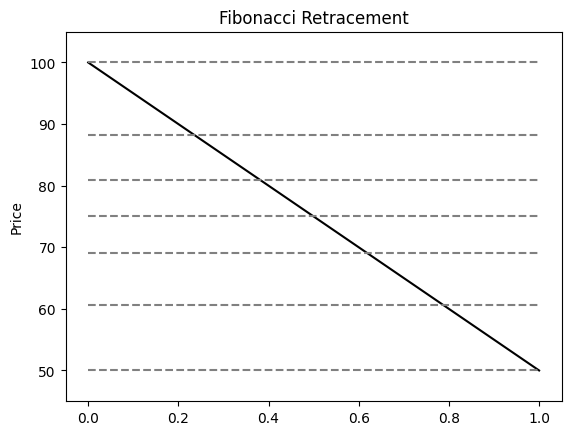

In [180]:
import numpy as np
import matplotlib.pyplot as plt

# Define the high and low prices
high_price = 100
low_price = 50

# Define the Fibonacci levels as percentages
fib_levels = [0, 0.236, 0.382, 0.5, 0.618, 0.786, 1]

# Calculate the retracement levels
retracement_levels = []
for level in fib_levels:
    retracement_levels.append(high_price - (high_price - low_price) * level)

# Plot the retracement levels
fig, ax = plt.subplots()
ax.plot([0, 1], [high_price, low_price], color='black')
for i in range(len(retracement_levels)):
    ax.plot([0, 1], [retracement_levels[i], retracement_levels[i]], linestyle='dashed', color='gray')
ax.set_ylim(low_price - (high_price - low_price)*0.1, high_price + (high_price - low_price)*0.1)
ax.set_ylabel('Price')
ax.set_title('Fibonacci Retracement')
plt.show()


In [169]:
calculate_price_levels(df)

,Open,High,Low,Close,Volume,Support Price Level,Resistance Price Level,Support Price Level 2,Resistance Price Level 2,Support Price Level 3,Resistance Price Level 3
Timestamp,,,,,,,,,,,
2023-03-24 23:45:00,1749.06,1750.49,1746.36,1749.69,67.4811,NaN,NaN,NaN,NaN,NaN,NaN
2023-03-25 00:00:00,1749.31,1751.41,1746.43,1751.41,126.5544,NaN,NaN,NaN,NaN,NaN,NaN
2023-03-25 00:15:00,1751.30,1753.71,1749.65,1753.71,86.4984,NaN,NaN,NaN,NaN,NaN,NaN
2023-03-25 00:30:00,1753.89,1758.34,1753.12,1756.83,113.8182,NaN,NaN,NaN,NaN,NaN,NaN
2023-03-25 00:45:00,1757.34,1757.53,1755.15,1756.71,45.3709,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2023-03-30 03:30:00,1781.86,1789.87,1780.84,1786.50,596.1400,NaN,NaN,NaN,NaN,NaN,NaN
2023-03-30 03:45:00,1786.35,1791.34,1785.50,1788.15,296.0126,NaN,NaN,NaN,NaN,NaN,NaN
2023-03-30 04:00:00,1786.84,1790.59,1785.91,1790.49,248.1811,NaN,NaN,NaN,NaN,NaN,NaN
